Lets break down the problem with mock data first!

In [1]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import OneHotEncoder

# Example data for hidden states of two different layers
# each row is a sample, each column is a dimension of the hidden state

hidden_state1 = np.array([[0.1, 0.3, 0.5],
                          [0.2, 0.4, 0.6],
                          [0.3, 0.1, 0.7],
                          [0.4, 0.6, 0.8],
                          [0.5, 0.7, 0.9]])

hidden_state2 = np.array([[0.2, 0.1, 0.3],
                          [0.3, 0.2, 0.4],
                          [0.4, 0.9, 0.5],
                          [0.5, 0.1, 0.6],
                          [0.6, 0.5, 0.7]])

# Example data for speaker labels
speakers = np.array(['speaker1', 'speaker2', 'speaker1', 'speaker3', 'speaker2'])

# One-Hot-Encoding for speaker labels
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(speakers.reshape(-1, 1))

# CCA for hidden_state1
cca1 = CCA(n_components=2)
cca1.fit(hidden_state1, Y)
X_c1, Y_c1 = cca1.transform(hidden_state1, Y)
corr1 = np.corrcoef(X_c1.T, Y_c1.T)[2:, :2]

# CCA for hidden_state2
cca2 = CCA(n_components=2)
cca2.fit(hidden_state2, Y)
X_c2, Y_c2 = cca2.transform(hidden_state2, Y)
corr2 = np.corrcoef(X_c2.T, Y_c2.T)[2:, :2]

print("Correlation for Hidden State 1:", np.max(corr1))
print("Correlation for Hidden State 2:", np.max(corr2))

if np.max(corr1) > np.max(corr2):
    print("Hidden State 1 is more correlated with speaker labels, therefore it contains more speaker information")
else:
    print("Hidden State 2 is more correlated with speaker labels, therefore it contains more speaker information")

Correlation for Hidden State 1: 0.8463298957557671
Correlation for Hidden State 2: 0.8968672899308715
Hidden State 2 is more correlated with speaker labels, therefore it contains more speaker information


Lets process the data for the experiment

In [10]:
import numpy as np
from tqdm import tqdm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import os
import glob

# Funktion zum Laden der Hidden States und Labels aus npy Dateien
def load_hidden_states_and_labels(root_dir, speakers, layer, max_files_per_speaker=50):
    all_hidden_states = []
    all_labels = []
    
    for speaker in tqdm(speakers):
        layer_path = os.path.join(root_dir, speaker, f'layer_{layer}')
        file_paths = glob.glob(os.path.join(layer_path, '*.npy'))[:max_files_per_speaker]
        for file_path in file_paths:
            hidden_states = np.load(file_path)
            if hidden_states.shape[2] == 1024:  # Überprüfen der Dimensionen
                hidden_states = hidden_states.reshape(-1, 1024)  # Umformung zu (n, 1024)
                all_hidden_states.append(hidden_states)
                labels = np.array([speaker] * hidden_states.shape[0]) # Erstellung der Labels für jeden Hidden State
                all_labels.append(labels)
    
    combined_hidden_states = np.vstack(all_hidden_states)
    combined_labels = np.hstack(all_labels)
    
    return combined_hidden_states, combined_labels

# Beispielhafte Sprecher und Anzahl der Layer
root_dir = 'data/all_speakers_w2vec_28.05'  # Anpassung notwendig
speakers = ['speaker_' + str(i) for i in range(1, 21)]
num_layers = 25  # Beispielhafte Anzahl von Layern

hidden_states = []
labels = []
Ys = []

encoder = OneHotEncoder(sparse_output=False)

for i in range(18, num_layers):
    print(f"Processing layer {i}")
    hidden_states_layer, labels_layer = load_hidden_states_and_labels(root_dir, speakers, i)
    hidden_states.append(hidden_states_layer)
    labels.append(labels_layer)
    Ys.append(encoder.fit_transform(labels_layer.reshape(-1, 1)))

Processing layer 18


100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


Processing layer 19


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Processing layer 20


100%|██████████| 20/20 [00:00<00:00, 47.87it/s]


Processing layer 21


100%|██████████| 20/20 [00:00<00:00, 38.16it/s]


Processing layer 22


100%|██████████| 20/20 [00:00<00:00, 42.80it/s]


Processing layer 23


100%|██████████| 20/20 [00:00<00:00, 46.43it/s]


Processing layer 24


100%|██████████| 20/20 [00:00<00:00, 45.80it/s]


Lets perform SVCCA like proposed by Maithra et al. 

In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

def compute_svd(X, threshold=0.99):
    U, S, Vt = svd(X, full_matrices=False)
    cumulative_variance = np.cumsum(S) / np.sum(S)
    num_components = np.searchsorted(cumulative_variance, threshold) + 1
    return U[:, :num_components] @ np.diag(S[:num_components]), num_components, Vt[:num_components]

def compute_cca(X, Y, num_components):
    cca = CCA(n_components=num_components)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    return X_c, Y_c, cca

def svcca(X, Y, threshold=0.99):
    X_svd, num_components_X, Vt_X = compute_svd(X, threshold)
    Y_svd, num_components_Y, Vt_Y = compute_svd(Y, threshold)
    
    num_components = min(num_components_X, num_components_Y)
    X_cca, Y_cca, cca_model = compute_cca(X_svd, Y_svd, num_components)
    
    return X_cca, Y_cca, cca_model, Vt_X, Vt_Y

def perform_svcca(hidden_states, labels):
    # Normalisieren der Hidden States und Labels
    scaler = StandardScaler()
    hidden_states_normalized = scaler.fit_transform(hidden_states)
    labels_normalized = scaler.fit_transform(labels)
    
    # SVCCA durchführen
    X_cca, Y_cca, cca_model, Vt_X, Vt_Y = svcca(hidden_states_normalized, labels_normalized)
    corr = np.corrcoef(X_cca.T, Y_cca.T)
    return corr, cca_model, Vt_X, Vt_Y

correlation_results = []

for i in range(len(hidden_states)):
    # Testen der SVCCA-Funktion mit identischen Hidden States
    correlation, cca_model, Vt_X, Vt_Y = perform_svcca(hidden_states[i], Ys[i])
    max_corr = np.max(correlation[:2, 2:])
    mean_corr = np.mean(correlation[:2, 2:])
    correlation_results.append((max_corr, mean_corr))
    print(f"Layer {i}: Max Corr = {max_corr}, Mean Corr = {mean_corr}")

In [24]:
max_correlations = [result[0] for result in correlation_results]

# Erstellen des DataFrame
results_df = pd.DataFrame({
    'Layer': range(len(hidden_states)),
    'Correlation': max_correlations
})

results_df.to_csv('results/svcca_results_10.csv', index=False)

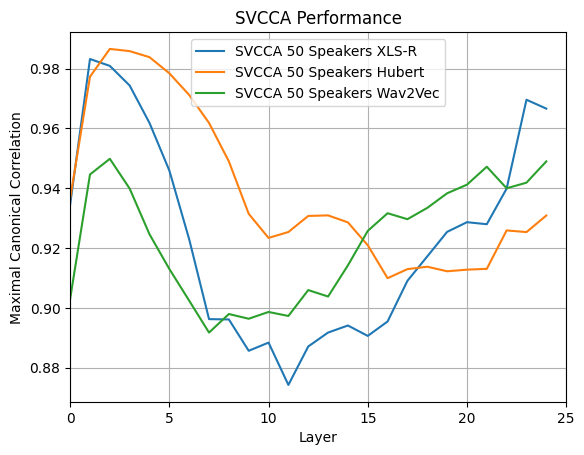

In [2]:
from matplotlib import pyplot as plt
import pandas as pd

svcca_results_5 = pd.read_csv('results/svcca_results_5.csv')['Correlation']
svcca_results_10 = pd.read_csv('results/svcca_results_10.csv')['Correlation']
svcca_results_20 = pd.read_csv('results/svcca_results_20.csv')['Correlation']
svcca_results_50 = pd.read_csv('results/svcca_results_50.csv')['Correlation']
svcca_results_5_w2v = pd.read_csv('results/svcca_results_5_w2v.csv')['Correlation']
svcca_results_10_w2v = pd.read_csv('results/svcca_results_10_w2v.csv')['Correlation']
svcca_results_20_w2v = pd.read_csv('results/svcca_results_20_w2v.csv')['Correlation']
svcca_results_50_w2v = pd.read_csv('results/svcca_results_50_w2v.csv')['Correlation']
svcca_results_5_hb = pd.read_csv('results/svcca_results_5_hb.csv')['Correlation']
svcca_results_10_hb = pd.read_csv('results/svcca_results_10_hb.csv')['Correlation']
svcca_results_20_hb = pd.read_csv('results/svcca_results_20_hb.csv')['Correlation']
svcca_results_50_hb = pd.read_csv('results/svcca_results_50_hb.csv')['Correlation']


#plt.plot(svcca_results_5)
#plt.plot(svcca_results_5_w2v, linestyle='dashed')
#plt.plot(svcca_results_5_hb, linestyle='dotted')
#plt.plot(svcca_results_10)
#plt.plot(svcca_results_10_w2v, linestyle='dashed')
#plt.plot(svcca_results_10_hb, linestyle='dotted')

plt.plot(svcca_results_50)
plt.plot(svcca_results_50_hb)
plt.plot(svcca_results_50_w2v)


plt.xlim(0, 25)
plt.xlabel('Layer')
plt.ylabel('Maximal Canonical Correlation')
plt.title('SVCCA Performance')
plt.legend(['SVCCA 50 Speakers XLS-R', 'SVCCA 50 Speakers Hubert', 'SVCCA 50 Speakers Wav2Vec', 'SVCCA 20 Speakers XLS-R', 'SVCCA 20 Speakers Wav2Vec', 'SVCCA 20 Speakers Hubert'])
plt.grid()
plt.show()

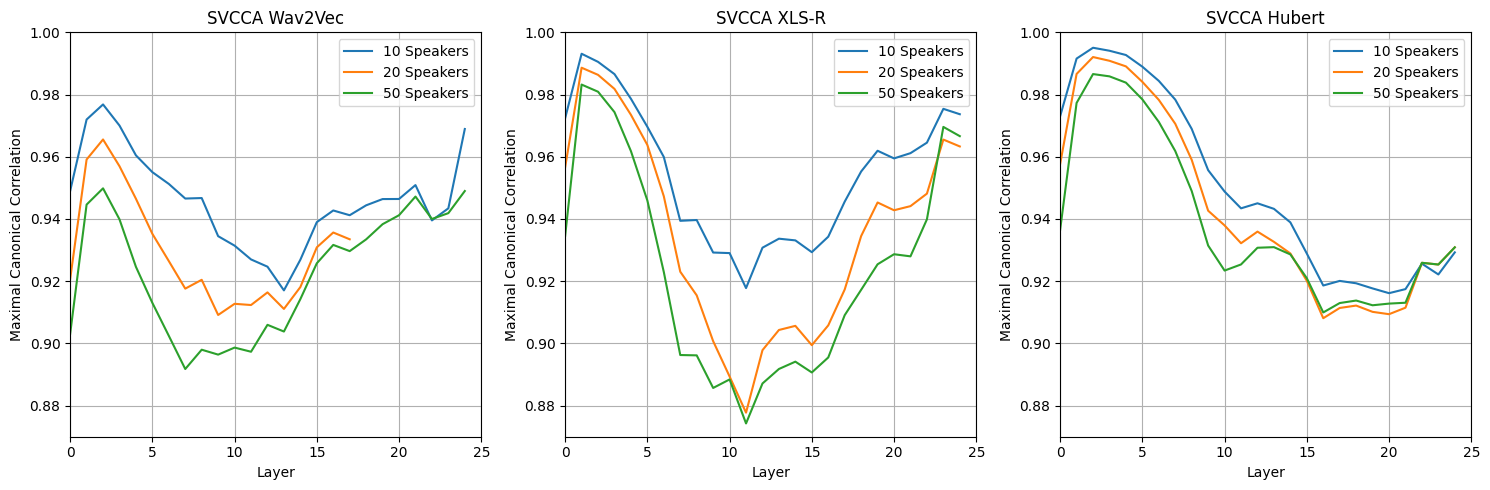

In [5]:
# make me three subplots horizontally stacked

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(svcca_results_10_w2v)
axs[0].plot(svcca_results_20_w2v)
axs[0].plot(svcca_results_50_w2v)

axs[1].plot(svcca_results_10)
axs[1].plot(svcca_results_20)
axs[1].plot(svcca_results_50)

axs[2].plot(svcca_results_10_hb)
axs[2].plot(svcca_results_20_hb)
axs[2].plot(svcca_results_50_hb)

axs[0].set_title('SVCCA Wav2Vec')
axs[1].set_title('SVCCA XLS-R')
axs[2].set_title('SVCCA Hubert')

for ax in axs:
    ax.set_xlabel('Layer')
    ax.set_ylabel('Maximal Canonical Correlation')
    ax.set_xlim(0, 25)
    ax.set_ylim(0.87, 1)
    ax.grid()

axs[0].legend(['10 Speakers', '20 Speakers', '50 Speakers'], loc='upper right')
axs[1].legend(['10 Speakers', '20 Speakers', '50 Speakers'], loc='upper right')
axs[2].legend(['10 Speakers', '20 Speakers', '50 Speakers'], loc='upper right')

plt.tight_layout()
plt.show()


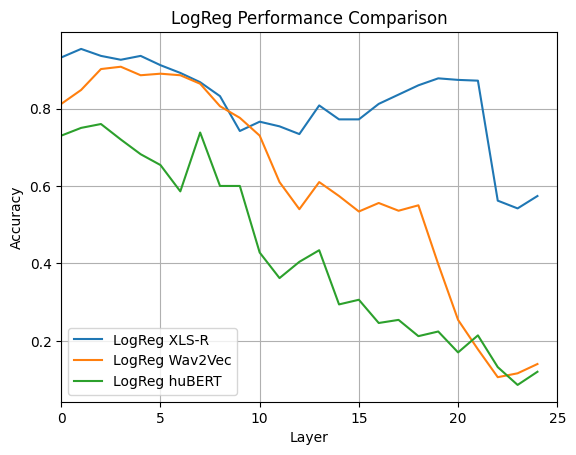

In [9]:
from matplotlib import pyplot as plt
import pandas as pd


logreg_xlsr = pd.read_csv('results/logreg_50_xlsr_cpu.csv')['accuracy']
logreg_hubert = pd.read_csv('results/logreg_50_huBERT_es.csv')['accuracy']
logreg_wav2vec = pd.read_csv('results/logreg_50_wav2vec_es.csv')['accuracy']

plt.plot(logreg_xlsr)
plt.plot(logreg_wav2vec)
plt.plot(logreg_hubert)

plt.xlim(0, 25)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('LogReg Performance Comparison')
plt.legend(['LogReg XLS-R','LogReg Wav2Vec', 'LogReg huBERT'])
plt.grid()
plt.show()

Now accelerate the process by using a GPU

In [11]:
from SVCCA import SVCCA

svcca = SVCCA(hidden_states=hidden_states, labels=Ys, use_gpu=False)

svcca.calculate_max_correlations()

svcca.save_results('results/svcca_results_20_w2v___2.csv')

Layer 0: Max Corr = 0.9385989646013009
